###  Planning Failures 
This is a high-level failure where the agent's initial plan is incorrect or incomplete. The agent might misinterpret the user's request and set out on the wrong path entirely.

Example: The user asks to find the correlation between two columns, but the agent's initial Thought is to calculate descriptive statistics for the entire DataFrame. It fails to correctly identify the specific task.

### Recognition Failures 
This is a critical failure mode directly related to the "noisy data" aspect of your thesis. The agent's plan may be sound, but it fails to recognize the correct data elements needed to execute the plan.

Example: The user asks for a count of claims labeled 'not enough info'. The agent's plan is to find a column with label values, but the label column has been shuffled and renamed to something else. The agent will try to access df['label'], which will result in a KeyError.

### Execution Failures
In this case, the agent correctly plans the task and identifies the necessary data, but the Python code it generates is flawed. This can be a syntax error, a logical bug, or an incorrect use of a library.

Example: The agent correctly identifies the label column but writes a line of code like df.group_by('label') instead of the correct df.groupby('label'). The Observation will return a NameError or a similar programming error.

### Interpretation Failures
This is an advanced failure mode where the code executes successfully, but the agent misinterprets the result. The agent might provide a final answer that is logically incorrect because it didn't correctly read or understand the output from the Python sandbox.

Example: The agent successfully runs code to find the mean, and the output is 35.2. However, its final answer states, "The average age is approximately 30." This shows a disconnect between the code output and the agent's final response. This can also happen when an error message is generated, and the agent, instead of trying to correct the code, incorrectly interprets the error message as a final answer.

In [1]:
import pandas as pd
import json

with open('data/sci_tab.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/sci_tab.json'

In [3]:
df.describe()

,paper,paper_id,table_caption,table_column_names,table_content_values,id,claim,label,table_id
count,1224,1224,1224,1224,1224,1224,1224,1224,1224
unique,80,80,213,194,216,1224,1212,3,213
top,Guided Dialog Policy Learning: Reward Estimati...,1908.10719v1,Table 3: Full-length ROUGE F-scores of some re...,"[Recall, 0.1, 0.2, 0.3, AUC]","[[Kryscinski et al. ( 2018 ), R-L, 40.2, 17.4,...",068fc4e5-d40c-4788-a5a7-bad858cbd7c7,"The Wiener filtering method shows lower DCE, b...",supports,b319e0cb-57b2-4ed0-a70d-7bfb1924edb3
freq,81,81,23,29,23,1,2,457,23


In [2]:
from sklearn.datasets import load_boston

boston_dataset=load_boston()
data = pd.DataFrame(boston_dataset.data,columns=boston_dataset.feature_names)
data['Price'] = boston_dataset.target
data

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [12]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph.message import add_messages

# LangChain imports
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain_experimental.utilities.python import PythonREPL

# Ollama-specific imports
from dotenv import load_dotenv
from langchain_ollama import ChatOllama

from typing import Annotated, TypedDict, List, Union
from config import OLLAMA_BASE_URL, LLM_MODEL

In [8]:
# --- Define the Agent State and Tool ---
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
@tool
def execute_python_code(code: str, file_path: str) -> str:
    """Execute a Python script in a sandboxed environment.
    The pandas library is already imported as 'pd', numpy as 'np',
    and the DataFrame is available as 'df'.
    
    The output of the code should be printed. For example: `print(df.head())`.
    
    Args:
        code: The Python code to execute, as a single string.
        file_path: The path to the data file to be loaded into the DataFrame.
    """
    repl = PythonREPL()
    try:
        exec_code = f"import pandas as pd\nimport numpy as np\nimport json\nwith open('{file_path}', 'r') as f:\n    data = json.load(f)\ndf = pd.json_normalize(data)\n{code}"
        output = repl.run(exec_code)
        return output
    except Exception as e:
        return f"Error executing code: {e}"

In [13]:
tools = [execute_python_code]
llm = ChatOllama(base_url=OLLAMA_BASE_URL, model=LLM_MODEL)

In [14]:
system_prompt = f"""
You are a highly skilled data analysis agent. Your primary goal is to perform in-depth data analysis on a pandas DataFrame.

Your workflow should follow these steps:
1.  **Initial Plan:** Start by thinking about the user's request and the best way to approach it.
2.  **Data Inspection:** You MUST begin by inspecting the DataFrame. Use `df.head()` or `df.info()` to understand its columns, data types, and any potential issues before taking action.
3.  **Action:** Write and execute Python code using the provided `execute_python_code` tool to perform the requested analysis.
4.  **Error Handling:** Carefully read the output of your code. If an error occurs, you must re-evaluate your plan and correct your code. For example, if you get a `KeyError`, you must re-inspect the DataFrame's columns to find the correct name.
5.  **Final Answer:** Once the analysis is complete and you have a result, provide a clear and concise final answer.

The DataFrame is available as the variable 'df'. Do not make assumptions about column names or data types without first inspecting the data.
"""

agent_executor = create_react_agent(
    model=llm,
    tools=tools,
    prompt=system_prompt,
)

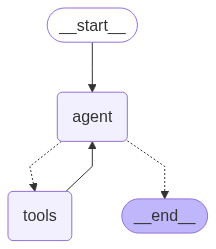

In [15]:
agent_executor

In [3]:
import pandas as pd
import json

with open('data/iris.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

In [4]:
df

,sepalLength,sepalWidth,petalLength,petalWidth,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [5]:
import random

original_columns = df.columns.tolist()
shuffled_columns = original_columns.copy()
random.shuffle(shuffled_columns)

# Create a mapping from old names to new names and apply it
rename_mapping = dict(zip(original_columns, shuffled_columns))
df.rename(columns=rename_mapping, inplace=True)
df

,petalWidth,sepalLength,sepalWidth,species,petalLength
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
